# Neuronal Network for signal language 

I worked with a portion of the SIGNS dataset created by deeplearning.ai for one of its specializations. The dataset consisted of photos of hands making the corresponding sign for a number between zero and five in international sign language.

The objective was to train an algorithm to identify, from a given photo, which number it represented.

### Load Data

In the following cell, I loaded a function that loads the data.

In [1]:
import h5py
import numpy as np
def load_dataset(path=''):
    train_dataset = h5py.File(path+'train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #  train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) #  train set labels

    test_dataset = h5py.File(path+'test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #  test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) #  test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train_full, y_train_full, X_test, y_test, classes = load_dataset()
y_train_full = y_train_full.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("Complete lecture")

Complete lecture


Here, we observe a sample of the data.

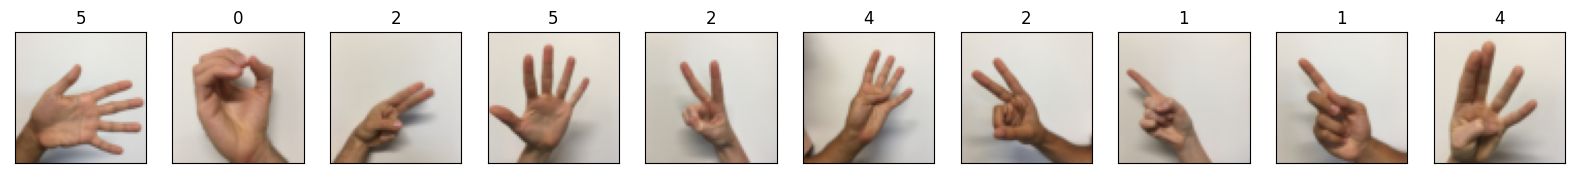

In [2]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title(str(y_train_full[i,0]))
    plt.imshow(X_train_full[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Data Exploration and Preparation

The X_train consists of 1080 images of 64x64 pixels x 3, as it has 3 RGB channels (red, green, blue). The y_train represents the numbers corresponding to the images (ranging from 0 to 1). The range of values for each pixel varies from 3 to 244.

In [3]:
print(X_train_full.shape)
print(y_train_full.shape)


(1080, 64, 64, 3)
(1080, 1)


### Normalizing the data appropriately for training 

In [4]:
# normalizing
print(X_train_full.min(), X_train_full.max())
print(X_test.min(), X_test.max())

X_train_full = X_train_full/244.0
X_test = X_test/241.0

print(X_train_full.min(), X_train_full.max())
print(X_test.min(), X_test.max())

4 244
3 241
0.01639344262295082 1.0
0.012448132780082987 1.0


### Separated 20% of the training set for use as validation data.

In [5]:
from sklearn.model_selection import train_test_split

X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(X_train_full, y_train_full, test_size=0.2,random_state=42) 

# Fully Connected Neural Network

For reproducibility purposes, I requested to set the following random seed before training.

In [6]:
import tensorflow as tf
import tensorflow.keras as keras

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

The labels in y_train_full and y_val_full were numbers between 0 and 5.The first step was to convert the class labels to one-hot encoding. 

### Convert the class labels to one-hot encoding. 

For this purpose, the keras.utils.to_categorical function (similar to sklearn's OneHotEncoder) was utilized.

In [7]:
from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
y_train_full_ohe = keras.utils.to_categorical(y_train_full)
y_test_ohe = keras.utils.to_categorical(y_test)
y_val_ohe = keras.utils.to_categorical(y_val_full)
print(y_train_full_ohe[:3], y_train_full[:3])

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]] [[4]
 [4]
 [4]]


I define the fully connected neural network.

In [8]:
def define_model():
    
    model_red1 = keras.models.Sequential()

    # Input layer
    model_red1.add(keras.layers.Flatten(input_shape=(64,64,3)))

    # Two hidden layers with 70 units each
    model_red1.add(keras.layers.Dense(70, activation='relu'))
    model_red1.add(keras.layers.Dense(70, activation='relu'))

    # Output layer. As this is a multi-class classification problem, use K (here 10) units.
    model_red1.add(keras.layers.Dense(6, activation='softmax'))
    
    return model_red1

model_red1 = define_model()

# mostrar el resumen
model_red1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 70)                860230    
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 6)                 426       
                                                                 
Total params: 865,626
Trainable params: 865,626
Non-trainable params: 0
_________________________________________________________________


### Compilation

What is the appropriate cost function for this problem? Since we are using 1-of-K encoding, the best cost function for our dataset is categorical_crossentropy.

* Compile the model using the ``adam`` optimizer. Add ``accuracy`` as a metric to monitor.

In [9]:
model_red1.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy', keras.metrics.Recall(class_id=5)])

### Training

I trained the model for at least 50 epochs, with a batch size of 32.

In [10]:
early = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True) # callbacks
history_red1 = model_red1.fit(epochs=50, batch_size=32, x=X_train_full, y=y_train_full_ohe, validation_data=(X_val_full, y_val_ohe), callbacks=[early,])

Epoch 1/50
27/27 [==============================] - 1s 25ms/step - loss: 2.1664 - accuracy: 0.1690 - recall: 0.0362 - val_loss: 1.7991 - val_accuracy: 0.1481 - val_recall: 0.0000e+00
Epoch 2/50
27/27 [==============================] - 0s 18ms/step - loss: 1.9355 - accuracy: 0.2407 - recall: 0.0000e+00 - val_loss: 1.6709 - val_accuracy: 0.2269 - val_recall: 0.0000e+00
Epoch 3/50
27/27 [==============================] - 0s 18ms/step - loss: 1.6356 - accuracy: 0.3206 - recall: 0.0000e+00 - val_loss: 1.5422 - val_accuracy: 0.3426 - val_recall: 0.0000e+00
Epoch 4/50
27/27 [==============================] - 0s 18ms/step - loss: 1.5868 - accuracy: 0.3611 - recall: 0.0000e+00 - val_loss: 1.5324 - val_accuracy: 0.3194 - val_recall: 0.0000e+00
Epoch 5/50
27/27 [==============================] - 1s 19ms/step - loss: 1.4939 - accuracy: 0.4062 - recall: 0.0000e+00 - val_loss: 1.4641 - val_accuracy: 0.4444 - val_recall: 0.0000e+00
Epoch 6/50
27/27 [==============================] - 0s 16ms/step - lo

27/27 [==============================] - 0s 15ms/step - loss: 0.4428 - accuracy: 0.8380 - recall: 0.7464 - val_loss: 0.5948 - val_accuracy: 0.8056 - val_recall: 0.7619
Epoch 47/50
27/27 [==============================] - 0s 16ms/step - loss: 0.3235 - accuracy: 0.9074 - recall: 0.8478 - val_loss: 0.7742 - val_accuracy: 0.7500 - val_recall: 0.7619
Epoch 48/50
27/27 [==============================] - 1s 19ms/step - loss: 0.4222 - accuracy: 0.8449 - recall: 0.7971 - val_loss: 0.8307 - val_accuracy: 0.7037 - val_recall: 0.3333
Epoch 49/50
27/27 [==============================] - 1s 22ms/step - loss: 0.4059 - accuracy: 0.8646 - recall: 0.8043 - val_loss: 0.6416 - val_accuracy: 0.7824 - val_recall: 0.4762
Epoch 50/50
27/27 [==============================] - 1s 26ms/step - loss: 0.3597 - accuracy: 0.8796 - recall: 0.8623 - val_loss: 0.6825 - val_accuracy: 0.7917 - val_recall: 0.6905


plot loss function

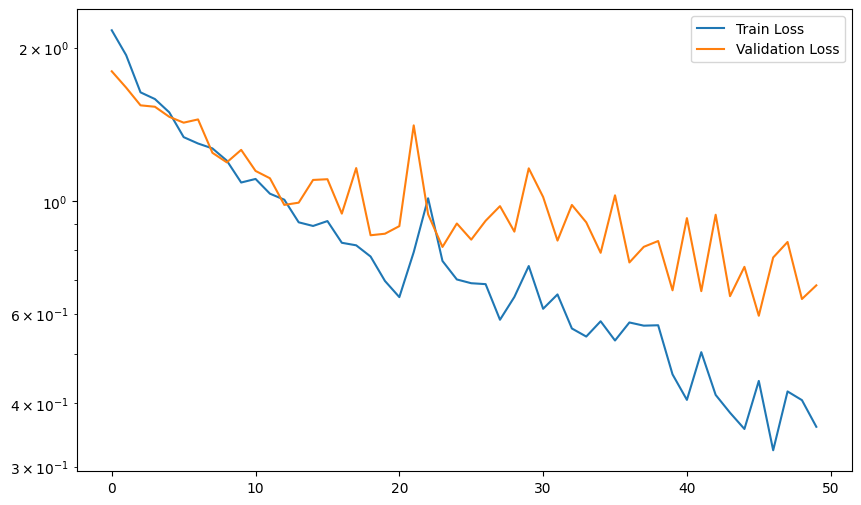

In [11]:
plt.figure(figsize=(10, 6))
plt.semilogy(history_red1.history['loss'], label='Train Loss')
plt.semilogy(history_red1.history['val_loss'], label='Validation Loss')
plt.legend(loc=0)

<AxesSubplot: >

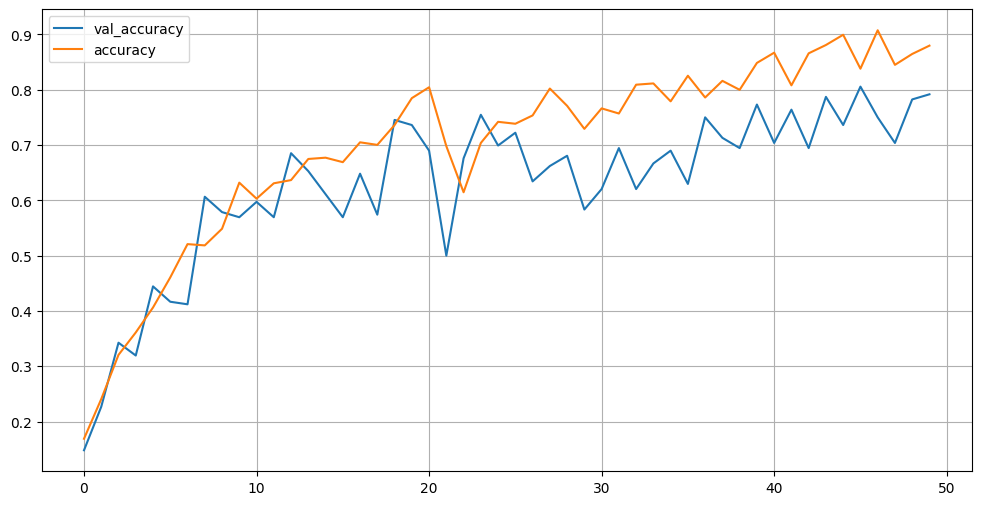

In [12]:
import pandas as pd
k = 'accuracy'
pd.DataFrame.from_dict(history_red1.history).plot(y=['val_'+k, k], grid=True, figsize=(12,6))

# Convolutional Neural Network

For reproducibility purposes, I requested to set the following random seed before training.

In [13]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

### Define NN

In [14]:
input_ = keras.layers.Input(shape=X_train_full.shape[1:]) #En este caso es necesario definir el Layer de Inputs
conv1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_)
conv2 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  padding='valid',activation='relu')(conv1)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
dropout1 = keras.layers.Dropout(0.25)(pool1)
flatten = keras.layers.Flatten()(dropout1)
hidden1 = keras.layers.Dense(512, activation="relu")(flatten)
dropout2 = keras.layers.Dropout(0.5)(hidden1)
output = keras.layers.Dense(6, activation="softmax")(dropout2)
model_red2 = keras.models.Model(inputs=[input_], outputs=[output])

### Compilation

In [15]:
model_red2.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
early_stopping_cb=keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [16]:
model_red2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                             

### Training

In [17]:
history_red2 = model_red2.fit(X_train_full, y_train_full[:,0], epochs=50, batch_size=32, validation_data=(X_val_full, y_val_full[:,0]),callbacks=[early_stopping_cb])

Epoch 1/50
27/27 [==============================] - 10s 319ms/step - loss: 1.8310 - accuracy: 0.1655 - val_loss: 1.7760 - val_accuracy: 0.1759
Epoch 2/50
27/27 [==============================] - 9s 352ms/step - loss: 1.7757 - accuracy: 0.2141 - val_loss: 1.7621 - val_accuracy: 0.3241
Epoch 3/50
27/27 [==============================] - 8s 276ms/step - loss: 1.7575 - accuracy: 0.2546 - val_loss: 1.7398 - val_accuracy: 0.2731
Epoch 4/50
27/27 [==============================] - 7s 262ms/step - loss: 1.7408 - accuracy: 0.2708 - val_loss: 1.7221 - val_accuracy: 0.2176
Epoch 5/50
27/27 [==============================] - 7s 254ms/step - loss: 1.6895 - accuracy: 0.3345 - val_loss: 1.6512 - val_accuracy: 0.3148
Epoch 6/50
27/27 [==============================] - 7s 252ms/step - loss: 1.6282 - accuracy: 0.3669 - val_loss: 1.5919 - val_accuracy: 0.4306
Epoch 7/50
27/27 [==============================] - 7s 253ms/step - loss: 1.5564 - accuracy: 0.3796 - val_loss: 1.5054 - val_accuracy: 0.3287
Epoch

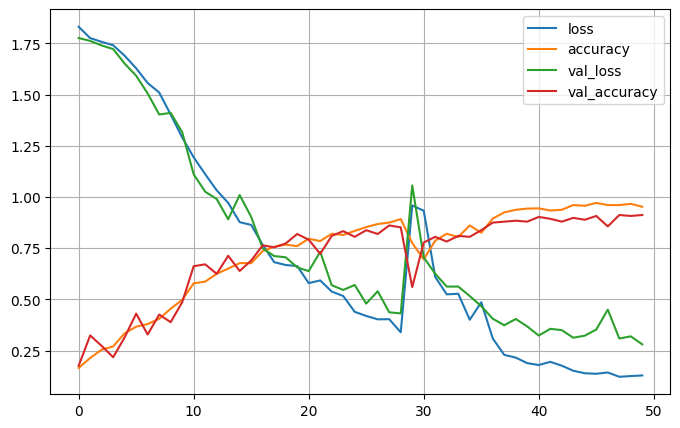

In [18]:
import pandas as pd

pd.DataFrame(history_red2.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

## Evaluation of the Networks

I performed all the following evaluations on the validation set.

In [19]:
# Evaluation Fully Connected
model_red1.evaluate(X_val_full, y_val_ohe)

7/7 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.7917 - recall: 0.6905


[0.6825249195098877, 0.7916666865348816, 0.6904761791229248]

### Predition for Fully Connected

In [20]:
# Compute predictions and find instances with error
y_predic_red1 = np.argmax(model_red1.predict(X_val_full), axis=1)

# Find errors
ierror= (y_predic_red1 - y_val_full.reshape(-1) != 0)

7/7 [==============================] - 0s 3ms/step


Probabilities

2/2 [==============================] - 0s 3ms/step


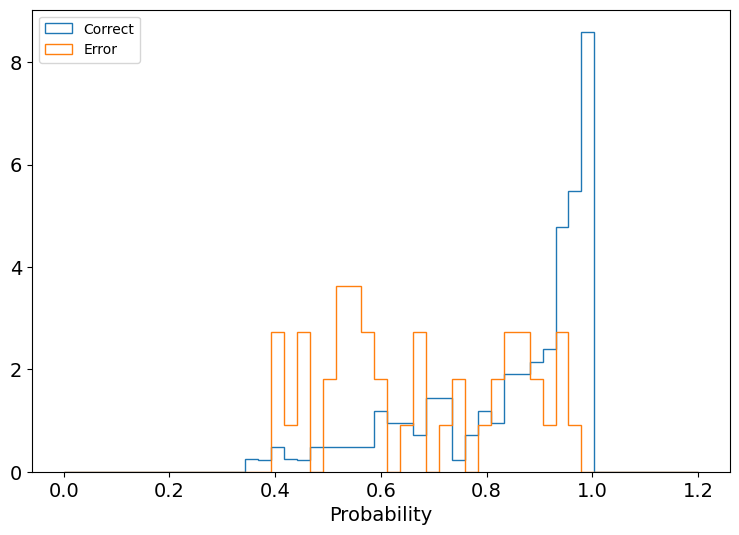

In [22]:
pred_proba_all = np.max(model_red1.predict(X_val_full), axis=1)

pred_proba_red1 = np.max(model_red1.predict(X_val_full[~ierror]), axis=1)
pred_proba_err_red1 = np.max(model_red1.predict(X_val_full[ierror]), axis=1)

#Let's see the probability
fig = plt.figure(figsize=(9,6))

bins = np.linspace(0, 1.2, 50)
plt.hist(pred_proba_red1, bins=bins, histtype='step', label='Correct', density=True)
plt.hist(pred_proba_err_red1, bins=bins, histtype='step', label='Error', density=True)

# Labels and ticks
plt.xlabel('Probability', size=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc=2)

### Predition for Convolutional Network

In [23]:
# Compute predictions and find instances with error
y_predic_red2 = np.argmax(model_red2.predict(X_val_full), axis=1)

# Find errors
ierror= (y_predic_red2 - y_val_full.reshape(-1) != 0)

7/7 [==============================] - 0s 46ms/step


Probabilities

1/1 [==============================] - 0s 62ms/step


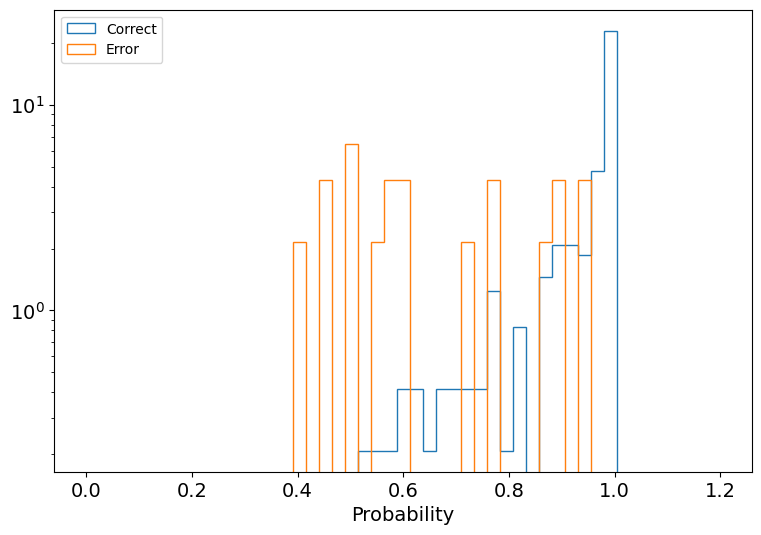

In [24]:
pred_proba_all_red2 = np.max(model_red2.predict(X_val_full), axis=1)

pred_proba_red2 = np.max(model_red2.predict(X_val_full[~ierror]), axis=1)
pred_proba_err_red2 = np.max(model_red2.predict(X_val_full[ierror]), axis=1)

# Veamos la distribución
fig = plt.figure(figsize=(9,6))

bins = np.linspace(0, 1.2, 50)
plt.hist(pred_proba_red2, bins=bins, histtype='step', label='Correct', density=True, log=True)
plt.hist(pred_proba_err_red2, bins=bins, histtype='step', label='Error', density=True)

# Labels and ticks
plt.xlabel('Probability', size=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc=2)

### Conclusion

I chose my final model based on the accuracy determined for the two networks. The convolutional network has higher accuracy, so I selected it as the best network for the problem.






In [27]:
y_test = y_test.reshape(-1,)

In [28]:
model_red2.evaluate(X_test, y_test)

4/4 [==============================] - 0s 39ms/step - loss: 0.3284 - accuracy: 0.9250


[0.3284201920032501, 0.925000011920929]

4/4 [==============================] - 0s 42ms/step


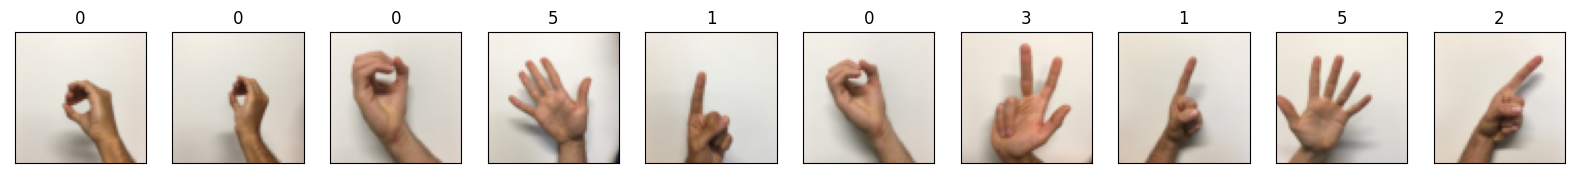

In [29]:
y_predic_Test = np.argmax(model_red2.predict(X_test), axis=1)

import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title(str(y_predic_Test[i]))
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()